In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
my_df = pd.read_csv('my_df.csv', index_col= 'Series')

In [3]:
exog_1 = np.array(my_df.iloc[0,6:50], dtype = np.float64).reshape(-1,1)
exog_2 = np.array(my_df.iloc[1,6:50], dtype = np.float64).reshape(-1,1)
exog_3 = np.array(my_df.iloc[2,6:50], dtype = np.float64).reshape(-1,1)
exog_4 = np.array(my_df.iloc[3,6:50], dtype = np.float64).reshape(-1,1)
exog_5 = np.array(my_df.iloc[4,6:50], dtype = np.float64).reshape(-1,1)
exog_6 = np.array(my_df.iloc[5,6:50], dtype = np.float64).reshape(-1,1)

# Plotting functions

In [4]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [5]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [6]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [7]:
Exog = np.concatenate([exog_1, exog_2, exog_3, exog_4], axis = 1)

In [8]:
def generate_problem_M3(n_elements, mode = 'prophet', seed = 123):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([exog_1, exog_2, exog_3, exog_4], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog)
    
    y_with_lags = generate_ts_2(Exog)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog, dtype=np.float64)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [9]:
def generate_problem_M3_nonlinear(n_elements, mode = 'prophet', seed = 123):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([exog_1, exog_2, exog_3, exog_4], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_nonlinear(Exog)
    
    y_with_lags = generate_ts_nonlinear_with_lags(Exog)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog, dtype=np.float64)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [10]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [11]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [12]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [13]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")

    model.fit(data_train_new)
    
    return model

In [14]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [15]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [16]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [17]:
def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y.squeeze() + 500 * np.random.randn(exog.shape[0])

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
        y[i] = y[i] + 1000 * np.random.randn(1)
    return y


def generate_ts_nonlinear(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = (0.1 * exog[:, 0] / exog[:, 1] * exog[:, 2] + 
                                        np.random.normal(0, 0.1 * exog.max(), size = exog.shape[0]))
    
    return y

def generate_ts_nonlinear_with_lags(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = (0.1 * exog[:, 0] / exog[:, 1] * exog[:, 2] + 
                                        np.random.normal(0, 0.1 * exog.max(), size = exog.shape[0]))
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
        
    return y


# Testing on the last dataset - linear case

# Prophet

In [18]:
# Global_mode
global_mode = 'prophet'

# Generate problem

In [19]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3_nonlinear(n_samples, mode = global_mode, seed = 123)

# Plotting

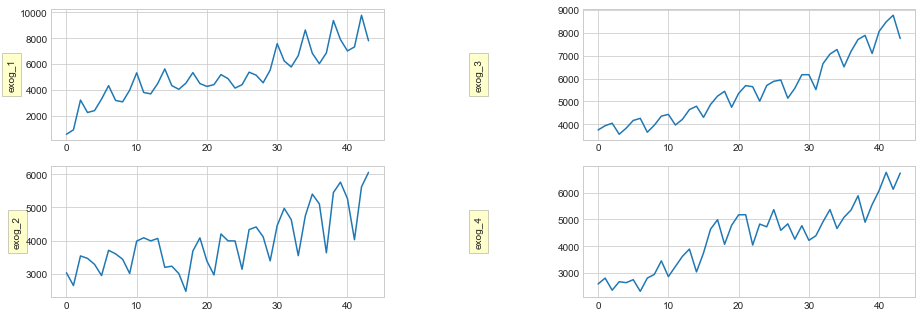

In [20]:
plotting_features(exog, global_mode)

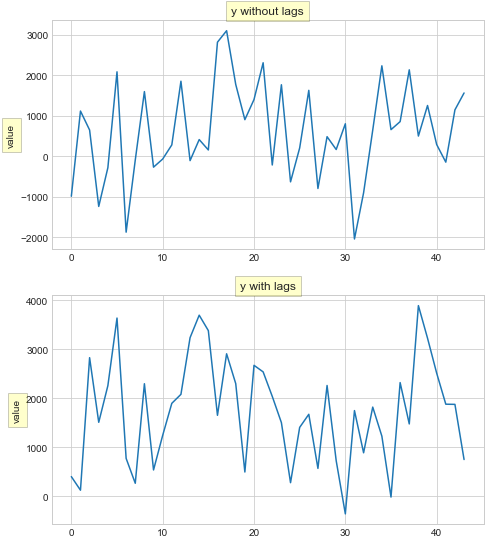

In [21]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [22]:
start_point = 0
middle_point = 30
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags without exog

# Prophet

In [23]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

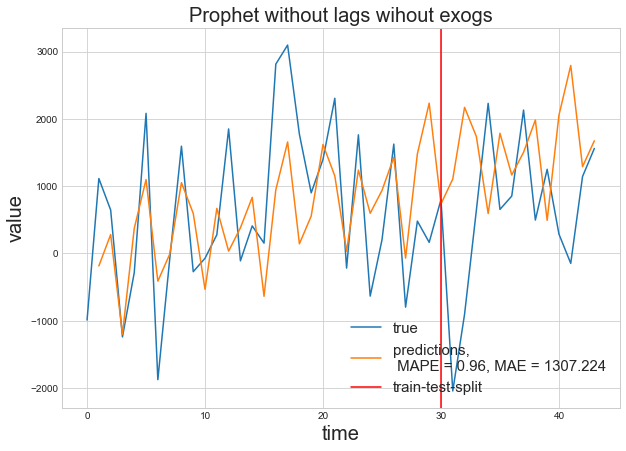

In [25]:
description = "Prophet without lags wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags with exogs

In [26]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

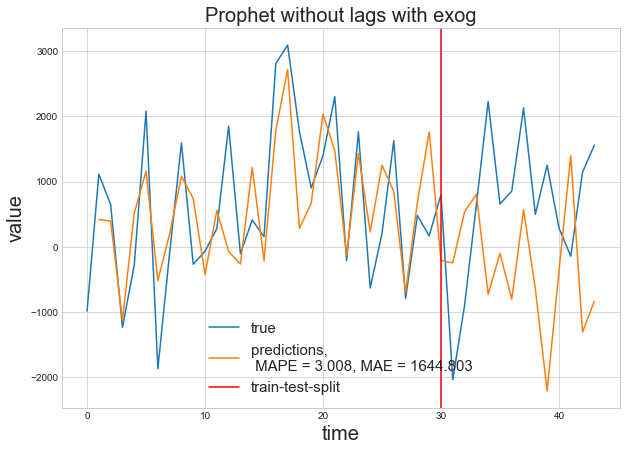

In [28]:
description = "Prophet without lags with exog"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags without exog

In [29]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

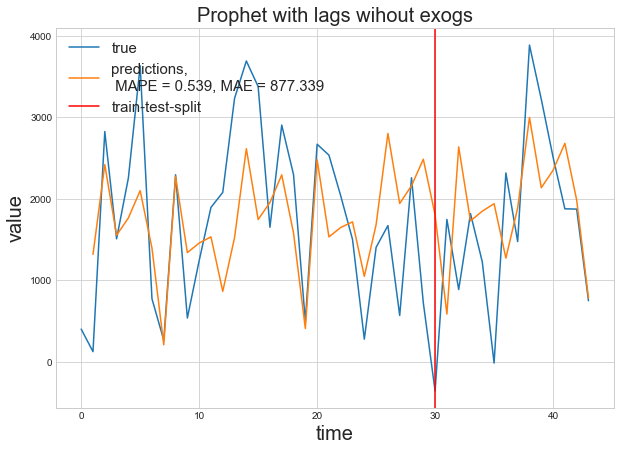

In [31]:
description = "Prophet with lags wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags with exogs

In [32]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

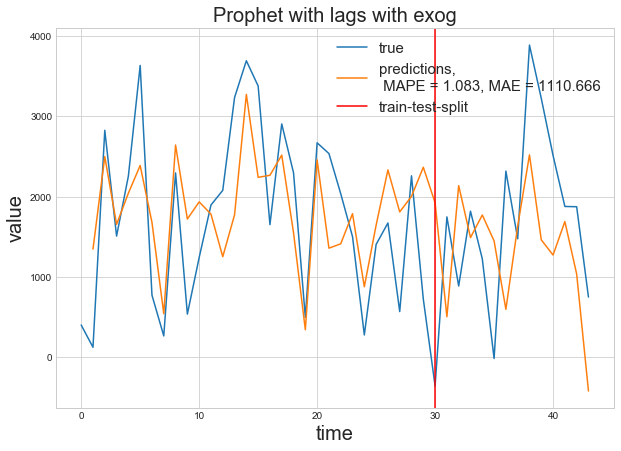

In [34]:
description = "Prophet with lags with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [35]:
# Global_mode
global_mode = 'pyramid'

# Generate problem

In [36]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3_nonlinear(n_samples, 
                                                                        mode = global_mode, seed = 123)

# Plotting

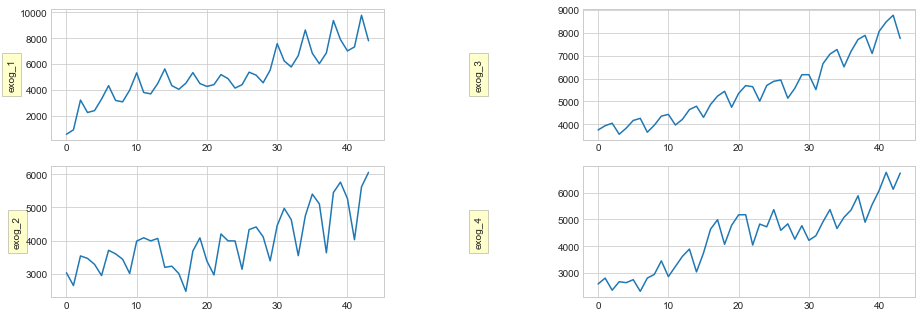

In [37]:
plotting_features(exog, global_mode)

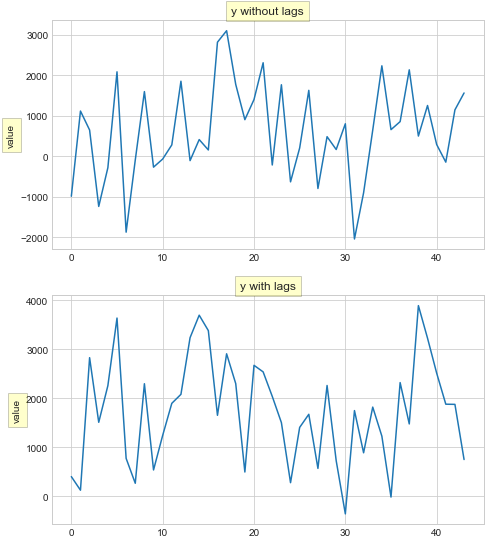

In [38]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [39]:
start_point = 0
middle_point = 30
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags without exog

In [40]:
params = {}
params['pyramid_mode'] = 'random_search'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 7
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [41]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                        SARIMAX   Log Likelihood                -255.340
Date:                Tue, 17 Jul 2018   AIC                            514.680
Time:                        16:00:13   BIC                            517.482
Sample:                             0   HQIC                           515.576
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    602.2354    222.032      2.712      0.007     167.060    1037.411
sigma2      1.447e+06   4.57e+05      3.167      0.002    5.51e+05    2.34e+06
===================================================================================
Ljung-Box (Q):                       21.86   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.83   Prob(JB):                         0.72
Heteroskedasticity (H):               0.60   Skew:                             0.17
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

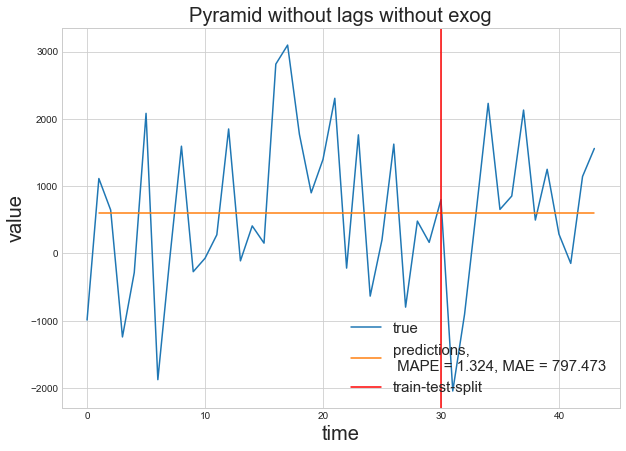

In [43]:
description = "Pyramid without lags without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags with exog

In [44]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'oob'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [45]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [46]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

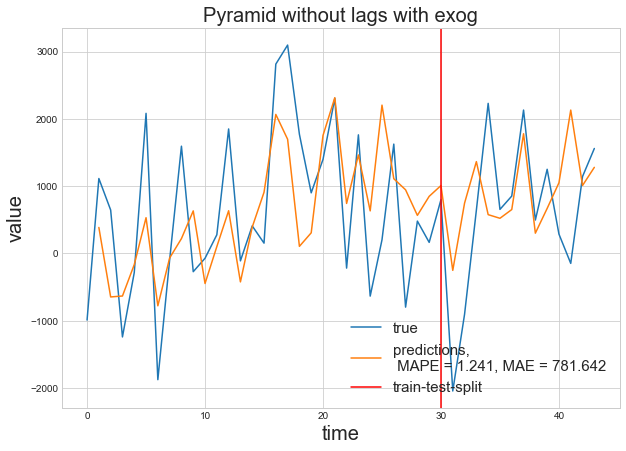

In [47]:
description = "Pyramid without lags with exog"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Pyramid with lags without exog

In [48]:
params = {}
params['pyramid_mode'] = 'random_search'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 7
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [49]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 4)   Log Likelihood                -248.979
Date:                           Tue, 17 Jul 2018   AIC                            505.959
Time:                                   16:00:25   BIC                            511.563
Sample:                                        0   HQIC                           507.752
                                            - 30                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2522.2103    511.823      4.928      0.000    1519.056    3525.365
ma.L1          0.4243      0.218      1.943      0.052      -0.004       0.852
ar.S.L4       -0.4058      0.212     -1.913      0.056      -0.822       0.010
sigma2      9.183e+05   4.42e+05      2.079      0.038    5.24e+04    1.78e+06
===================================================================================
Ljung-Box (Q):                       31.42   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.35   Prob(JB):                         0.33
Heteroskedasticity (H):               0.62   Skew:                             0.21
Prob(H) (two-sided):                  0.47   Kurtosis:                         1.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

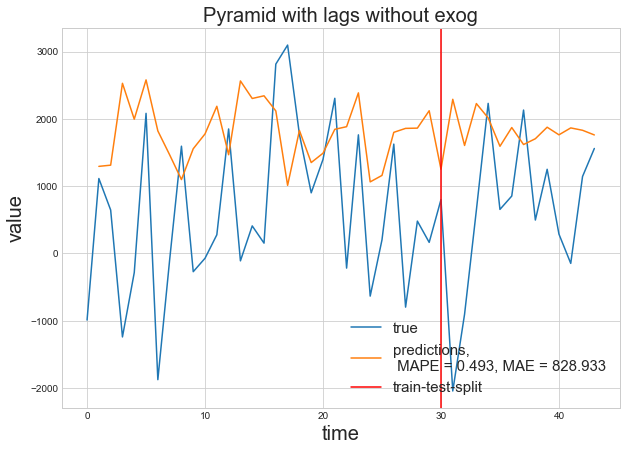

In [51]:
description = "Pyramid with lags without exog"
plot_results(data_without_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags with exog

In [52]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'oob'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [53]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [54]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

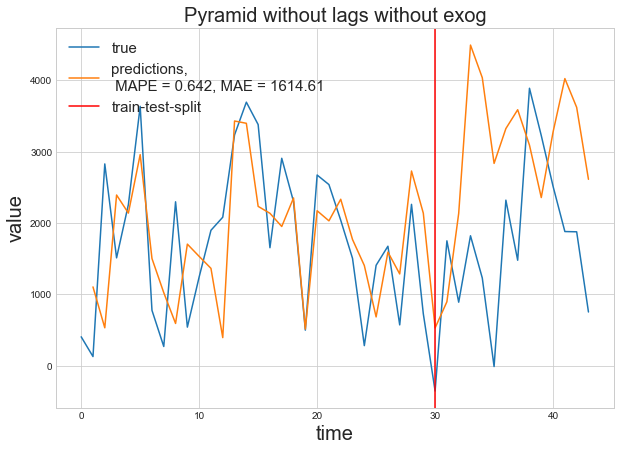

In [55]:
description = "Pyramid without lags without exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)